In [1]:
from src.generation import generate_k_parameters
from src.zsoc import OCV_curve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import the dataset
df = pd.read_csv('./res/K_para.csv')
df = df.drop(columns=['Sample No.', 'Battery Manufacturer', 'Serial Number', 'Cell Number'])
data = df.to_numpy()

In [3]:
# expand the dataset to 1000 entries
batteries = generate_k_parameters(data, n=1000)

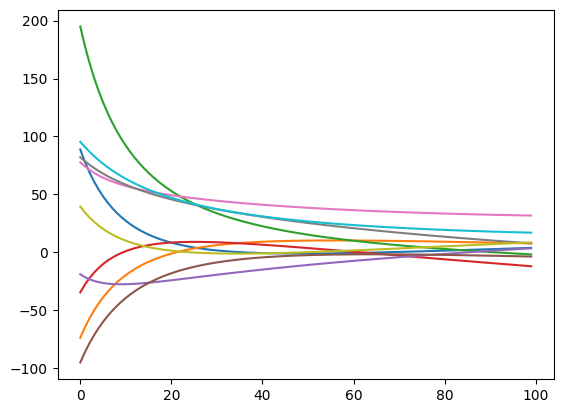

In [4]:
# plot the last 10 batteries
for battery in batteries[-10:]:
    b = OCV_curve(battery)
    plt.plot(b['zsoc'], b['Vo'])
plt.show()